In [153]:
from datasets import list_datasets, load_dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plot

In [222]:
all_chars = " !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz`\n"
ctoi = {c:i for i,c in enumerate(all_chars)}
itoc = {i:c for i,c in enumerate(all_chars)}

unknown_i = len(all_chars)
vocab_size = len(all_chars) + 1

In [223]:
dataset = load_dataset("bookcorpus", streaming=True, split="train")

In [224]:
next(iter(dataset))

{'text': 'usually , he would be tearing around the living room , playing with his toys .'}

In [225]:
valid_ds = dataset.take(10000)
train_ds = dataset.skip(10000)

In [226]:
train_itr = iter(train_ds)

In [227]:
txt = [next(train_itr)["text"] for _ in range(10)]
txt

["`` looks like we have another one . ''",
 'and so my daughter was born , totally unexpected but completely loved .',
 "the end chapter one i bounce from foot to foot as i try my mom 's cell phone one more time .",
 "i 'm practically bursting at the seams wanting to tell her my good news , and she 's not answering .",
 'i hang up the call as it goes to her voicemail again .',
 "she 's been a little more unreachable ever since she started dating this new mystery man .",
 "she 'll have to break down and tell me about him soon-we 've never been able to keep secrets from one another for long .",
 'i give up and hold down the number 2 button on my old flip-phone to auto-dial my best friend allison .',
 'thankfully , she picks up .',
 '`` i got it !']

In [228]:
# return list of int
def encode(txt):
    return [ctoi.get(c, unknown_i) for c in txt]

def decode(x):
    return "".join([itoc[i] for i in x])

In [229]:
x = encode("hello")
decode(x)

'hello'

In [230]:
block_size = 32
train_itr = iter(train_ds)
valid_itr = iter(valid_ds)

# (B, L)
def next_batch(split="train", iter_size=64):
    global train_itr, valid_itr
    itr = train_itr if split == "train" else valid_itr
    
    try: 
        data = [next(itr)["text"] for _ in range(iter_size)]
    except StopIteration:
        if split == "train":
            train_itr = iter(train_ds)
        else:
            valid_itr = iter(valid_ds)
            
        itr = train_itr if split == "train" else valid_itr
        data = [next(itr)["text"] for _ in range(iter_size)]
    
     
    txt = "".join(data) # concat datas into a single long string
    x = torch.tensor(encode(txt))
    y = x[1:]
    batch_size = len(y) // block_size
    xb = x[:batch_size*block_size].view(-1, block_size)
    yb = y[:batch_size*block_size].view(-1, block_size)
        
    return xb, yb
        
xb, yb = next_batch()
xb.shape

torch.Size([161, 32])

In [231]:
xb[10], yb[10]

(tensor([38, 56,  0, 46, 57,  0, 44, 52, 42, 56,  0, 57, 52,  0, 45, 42, 55,  0,
         59, 52, 46, 40, 42, 50, 38, 46, 49,  0, 38, 44, 38, 46]),
 tensor([56,  0, 46, 57,  0, 44, 52, 42, 56,  0, 57, 52,  0, 45, 42, 55,  0, 59,
         52, 46, 40, 42, 50, 38, 46, 49,  0, 38, 44, 38, 46, 51]))

In [232]:
x = xb[10].tolist()
y = yb[10].tolist()
decode(x), decode(y)

('as it goes to her voicemail agai', 's it goes to her voicemail again')

In [233]:
ci = [ci for x in xb for ci in x]
unknon_count = [i for i in ci if i == unknown_i]

print(len(concat))
print(len(unknon_count))

3840
1


In [234]:
#!/usr/bin/env python
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F


@dataclass
class Config:
    vocab_size: int
    block_size: int
    emb_size: int
    head_num: int
    head_size: int
    layer_num: int
    ctoi: dict
    dropout: float


class MultiHeadAttension(nn.Module):

    def __init__(self, c: Config):
        super().__init__()
        assert c.emb_size / c.head_size == c.head_num

        self.head_size = c.head_size
        self.head_num = c.head_num
        self.attn = nn.Linear(
            c.emb_size, 3 * c.head_num * c.head_size, bias=False)
        self.ffn = nn.Linear(c.head_num * c.head_size, c.emb_size, bias=False)

        self.attn_dropout = nn.Dropout(c.dropout)
        self.resid_dropout = nn.Dropout(c.dropout)

    # x: (B, L, C)
    # return: (B, L, C)
    def forward(self, x):
        B, L, C = x.shape

        z = self.attn(x)  # (B, L, 3 * hn * hs)
        k, q, v = torch.split(
            z, self.head_num * self.head_size, dim=2)  # (B, L, hn * hs)

        k = k.view(B, L, self.head_num, self.head_size).permute(
            0, 2, 1, 3)  # (B, hn, L, hs)
        q = q.view(B, L, self.head_num, self.head_size).permute(0, 2, 1, 3)
        v = v.view(B, L, self.head_num, self.head_size).permute(0, 2, 1, 3)

        q = q.permute(0, 1, 3, 2)  # (B, hn, hs, L)
        attn = (k @ q) / self.head_size**0.5  # (B, hn, L, L)
        mask = torch.tril(torch.ones(L, L)) == 0
        mask = mask.to(x.device)
        attn = attn.masked_fill(mask, -float('inf'))  # (B, hn, L, L)
        attn = F.softmax(attn, dim=3)
        attn = self.attn_dropout(attn)

        y = attn @ v  # (B, hn, L, hs)
        y = y.permute(0, 2, 1, 3)  # (B, L, hn, hs)
        y = y.contiguous().view(B, L, -1)  # (B, L, hn * hs)
        y = self.ffn(y)  # (B, L, C)
        y = self.resid_dropout(y)

        return y


class FeedForward(nn.Module):

    def __init__(self, c: Config):
        super().__init__()
        self.linear1 = nn.Linear(c.emb_size, 2 * c.emb_size)
        self.linear2 = nn.Linear(2 * c.emb_size, c.emb_size)
        self.dropout = nn.Dropout(c.dropout)

    # (B, L, C)
    def forward(self, x):
        y = self.linear1(x)
        y = torch.relu(y)
        y = self.linear2(y)
        y = self.dropout(y)

        return y


class Block(nn.Module):

    def __init__(self, c: Config):
        super().__init__()

        assert c.emb_size % c.head_size == 0
        assert c.emb_size / c.head_size == c.head_num

        self.mha = MultiHeadAttension(c)
        self.lnorm1 = nn.LayerNorm(c.emb_size)
        self.lnorm2 = nn.LayerNorm(c.emb_size)
        self.ffn = FeedForward(c)

    # x: (B, L, emb)
    def forward(self, x):
        y = self.mha(x) + x
        y = self.lnorm1(y)
        y = self.ffn(y) + y
        y = self.lnorm2(y)
        return y


class Transformer(nn.Module):

    def __init__(self, c: Config):
        super().__init__()
        self.config = c
        self.embed = nn.Embedding(c.vocab_size, c.emb_size)
        self.dropout = nn.Dropout(c.dropout)
        self.blocks = nn.Sequential(
            *[Block(c) for _ in range(c.layer_num)]
        )
        self.proj = nn.Linear(c.emb_size, c.vocab_size)

    # return (L, C)
    def pos_encoding(self, x):
        B, L, C = x.shape
        pos = torch.arange(0, L).view(-1, 1)  # (L, 1)
        div = 2 * torch.arange(0, C) / C  # (C)
        div = torch.pow(10000, div)  # (C)
        e = pos / div
        pe = torch.zeros(L, C)
        pe[:, 0::2] = torch.sin(e[:, 0::2])
        pe[:, 1::2] = torch.cos(e[:, 1::2])

        pe = pe.to(x.device)
        return pe

    # (B, L) -> (B, L, C)
    def forward(self, x):
        y = self.embed(x)  # (B, L, emb)
        y = y + self.pos_encoding(y)  # (B, L, emb)
        y = self.dropout(y)
        y = self.blocks(y)  # (B, L, emb)
        y = self.proj(y)  # (B, L, vocab)

        return y

    @torch.no_grad()
    def sample(self, max_len):
        self.eval()
        itoc = {i: c for c, i in self.config.ctoi.items()}
        tks = [0] * self.config.block_size

        for i in range(max_len):
            ctx = torch.tensor(tks[i:i+self.config.block_size])  # (L)
            ctx = ctx.view(1, -1)  # (B, L)

            logits = self.forward(ctx)  # (B, L, C)
            probs = F.softmax(logits, dim=2)  # (B, L, C)
            # (C), # the last in the sequence is the newly generated
            probs = probs[0, -1, :]
            yi = torch.multinomial(probs, 1)
            tks.append(yi.item())

        tks = tks[self.config.block_size:]
        chars = [itoc.get(t, "_") for t in tks]
        self.train()
        return "".join(chars)

In [235]:
@torch.no_grad()
def eval_split(model, split):
    model.eval()
    
    xb, yb = next_batch(split, 1000)
    logits = model(xb)
    B, L, C = logits.shape
    logits = logits.view(B*L, C)
    yb = yb.view(-1)
    loss = F.cross_entropy(logits, yb)
    
    model.train()
    return loss.item()

In [236]:
config = Config(
    vocab_size=vocab_size,
    block_size=block_size,
    emb_size=128,
    head_size=32,
    head_num=128//32,
    layer_num=2,
    ctoi=ctoi,
    dropout=0
)

model = Transformer(config)
optim = torch.optim.Adam(model.parameters())
lossi = []

In [237]:
model.sample(100)

'ozZqUyuhBeUd?YzTkLjyBObbQpprN:bfkmYq3Bq.gJZSZd?aAdKVZ`bypg;LLkHY!DEeIG3dMOjvFY_Pvl?OyRdEk:,w!N!Ej!&D'

In [238]:
epoch = 3000
eval_iterval = 300

model.train()

for i in range(epoch):
    optim.zero_grad()
    xb, yb = next_batch() # (B, L) 
    logits = model(xb)
    B, L, C = logits.shape

    logits = logits.view(B*L, C)
    yb = yb.view(-1)
    loss = F.cross_entropy(logits, yb)
    loss.backward()
    optim.step()
    
    if i % eval_iterval == 0:
        tr_loss = eval_split(model, "train")
        va_loss = eval_split(model, "valid")
        lossi.append((tr_loss, va_loss))
        print(f"{tr_loss:.4f} {va_loss:.4f}")

3.8468 3.8532
1.8144 1.8252
1.5478 1.7619
1.5171 1.6246
1.5457 1.6206
1.5170 1.5444
1.3800 1.5289
1.4520 1.5634
1.4369 1.5003
1.4380 1.4875


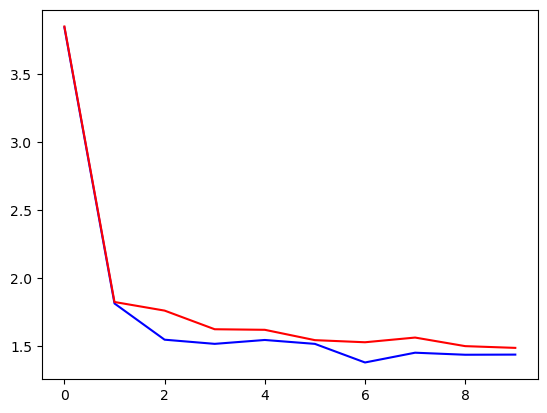

In [239]:
tr_loss = [t for t, v in lossi]
va_loss = [v for t, v in lossi]

plot.plot(tr_loss, "b")
plot.plot(va_loss, "r")

In [240]:
print(model.sample(300))

''s jacking my put have as afrom her face , infacting a job , which home go next forward man away , golden in amportunclard forween stitched again from the given that read her old , i would have daring time my times , will they wrould treed it .but a nodden coat trajine ?my deep .before , he pict th


## Fine-tuning on Shakespeare

In [241]:
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [242]:
txt = open('shakespeare.txt', 'r').read()
txt[0:100]

"                     1\n  From fairest creatures we desire increase,\n  That thereby beauty's rose mig"

In [243]:
data = encode(txt)
i = int(0.9 * len(data))
tr_data = data[0:i]
va_data = data[i:]

In [244]:
def next_batch_shake(split="train", batch_size=32):
    data = tr_data if split == "train" else va_data
    xi = torch.randint(0, len(data)-block_size, (batch_size,))
    x = torch.tensor([data[i:i+block_size] for i in xi])
    y = torch.tensor([data[i+1:i+block_size+1] for i in xi])
    
    return x, y

In [245]:
@torch.no_grad()
def eval_split_shake(model, split):
    model.eval()
    
    xb, yb = next_batch_shake(split, 1000)
    logits = model(xb)
    B, L, C = logits.shape
    logits = logits.view(B*L, C)
    yb = yb.view(-1)
    loss = F.cross_entropy(logits, yb)
    
    model.train()
    return loss.item()

In [252]:
model = Transformer(config)
optim = torch.optim.Adam(model.parameters(), lr=0.001) # default lr=0.001
lossi = []

In [ ]:
epoch = 3000
eval_iterval = 300
model.train()

for i in range(epoch):
    optim.zero_grad()
    xb, yb = next_batch_shake() # (B, L) 
    logits = model(xb)
    B, L, C = logits.shape

    logits = logits.view(B*L, C)
    yb = yb.view(-1)
    loss = F.cross_entropy(logits, yb)
    loss.backward()
    optim.step()
    
    if i % eval_iterval == 0:
        tr_loss = eval_split_shake(model, "train")
        va_loss = eval_split_shake(model, "valid")
        lossi.append((tr_loss, va_loss))
        print(f"{tr_loss:.4f} {va_loss:.4f}")

1.5078 1.5959
1.4724 1.6125
1.4879 1.6239
1.4672 1.6167
1.4554 1.5861
1.4898 1.6189
1.4634 1.5947
1.4806 1.5939
1.4828 1.5971


# log
- no pre-train: 1.60
- pre-train: 1.60

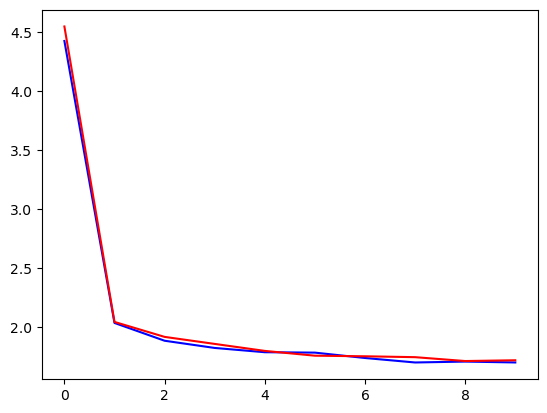

In [248]:
tr_loss = [t for t, v in lossi]
va_loss = [v for t, v in lossi]

plot.plot(tr_loss, "b")
plot.plot(va_loss, "r")

In [251]:
print(model.sample(1000))

    noted he seat will, groood- Contice fathror,
    Who.  Cactly pruntices them to know mine any riting as of make then foosic we final a buddom thought his dear much coud,
    And reithine a dunker of his earn'd leaved!
  TAMUTHIP RD. You swear in of home, weave, honourague,
  Hee which thint
            as fair mother outump to your light to deat of RGome of sair,
    And commagine; this worshee's and fause!
     sonfess trued;
    Remious odd me afform lesse and me and come.
    How show not this force. How for Come that lordm?
  OTR DOLLETA. Beligh sounce.
   That I this fan sould My thy
    deat; been to hand.
   Grons' then of answer
    Let but as for viliblius arthiness no caine,
    Do both you for me blooding his exephow'd not inter iking peoper'd. Iurgew nover and world
    gate
    You my prove retunes. Well stee-stor,; for me shoodn.
  Mows this Give off stoat the saway, and head meusin,
     Ekne's that encount thostrely and rever bittle indantal bout thou ushardon.
  FA